In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [6]:
raw_df = pd.read_csv('../assets/hw_2_2/customer_segmentation_train.csv', index_col=0)

display(raw_df.head())

print(raw_df.info())
print(raw_df.isnull().sum())

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


<class 'pandas.core.frame.DataFrame'>
Index: 8068 entries, 462809 to 461879
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 693.3+ KB
None
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64


Segmentation
A    1578
B    1486
C    1576
D    1814
Name: count, dtype: int64


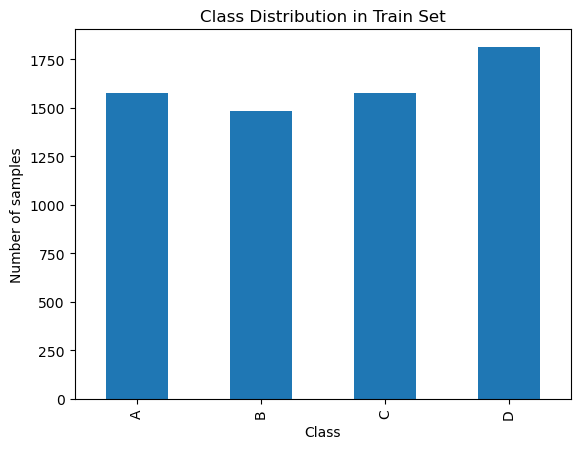

In [7]:
X = raw_df.drop(columns=['ID', 'Segmentation'], errors='ignore')
y = raw_df['Segmentation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
    ('cat', cat_pipeline, categorical_cols)
])

class_counts = pd.Series(y_train).value_counts().sort_index()

print(class_counts)

class_counts.plot(kind='bar', title='Class Distribution in Train Set')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

In [8]:
target_le = LabelEncoder()
y_train_enc = target_le.fit_transform(y_train)
y_test_enc = target_le.transform(y_test)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Any NaNs in train:", np.isnan(X_train_processed).any())
print("Any NaNs in test:", np.isnan(X_test_processed).any())

Any NaNs in train: False
Any NaNs in test: False


**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [9]:
pipeline_orig = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

pipeline_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

pipeline_smote_tomek = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote_tomek', SMOTETomek(smote=SMOTE(random_state=42), random_state=42)),
    ('classifier', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [10]:
pipeline_orig.fit(X_train, y_train_enc)
y_pred_orig = pipeline_orig.predict(X_test)

print("Classification report on original data:\n")
print(classification_report(y_test_enc, y_pred_orig, target_names=target_le.classes_))

pipeline_smote.fit(X_train, y_train_enc)
y_pred_smote = pipeline_smote.predict(X_test)

print("Classification report on SMOTE data:\n")
print(classification_report(y_test_enc, y_pred_smote, target_names=target_le.classes_))

pipeline_smote_tomek.fit(X_train, y_train_enc)
y_pred_smote_tomek = pipeline_smote_tomek.predict(X_test)

print("Classification report on SMOTE-Tomek data:\n")
print(classification_report(y_test_enc, y_pred_smote_tomek, target_names=target_le.classes_))

Classification report on original data:

              precision    recall  f1-score   support

           A       0.42      0.45      0.43       394
           B       0.41      0.18      0.25       372
           C       0.49      0.61      0.54       394
           D       0.65      0.76      0.70       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614

Classification report on SMOTE data:

              precision    recall  f1-score   support

           A       0.42      0.48      0.45       394
           B       0.41      0.25      0.31       372
           C       0.51      0.59      0.55       394
           D       0.68      0.71      0.70       454

    accuracy                           0.52      1614
   macro avg       0.51      0.51      0.50      1614
weighted avg       0.51      0.52      0.51      1614

Classification report on SMOTE-Tomek data:

       

### Summary

Three logistic regression models were evaluated: one trained on the original data, one on SMOTE-balanced data, and one on SMOTE-Tomek resampled data. All models were evaluated using a one-vs-rest strategy and compared on the same test set.

**Main metric chosen:** Macro F1-score, as it balances precision and recall across all classes equally, making it suitable for multiclass evaluation.

**Results overview:**
- **Original data:** Macro F1 ≈ 0.48
- **SMOTE:** Macro F1 ≈ 0.50
- **SMOTE-Tomek:** Macro F1 ≈ 0.49

The SMOTE-balanced model showed slightly higher macro F1-score and better recall in some minority classes, but overall differences between models were small.

The relatively balanced distribution of classes (as seen in the train set distribution) explains why SMOTE and SMOTE-Tomek did not drastically improve performance: the dataset does not have a strong class imbalance, so oversampling had a limited impact.

**Conclusion:**
All models show comparable performance, with the SMOTE model being slightly better by macro F1. However, the original data already provides reasonable balance, so additional resampling does not significantly change results.

